# Чуйкин Никита
# Проект e-commerce

# Задачи:

In [1]:
# Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

# 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

# 5. Напиши функцию на python, позволяющую строить когортный анализ.
#    В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.

# 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
#    В кластеризации можешь выбрать следующие метрики: R, F, M. Подробно опиши, как ты создавал кластеры.
#    Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import plotly.express as px

import warnings
from operator import attrgetter
import matplotlib.colors as mcolors

sns.set(rc={'figure.figsize':(13, 5)})


In [3]:
customers = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FUi5uSd6BfG_ig")
items = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw")
orders = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/t9Li4JOfgxuUrg")

# Описание таблиц

In [4]:
#customers — таблица с уникальными идентификаторами пользователей

#customer_id — позаказный идентификатор пользователя
#customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
#customer_zip_code_prefix —  почтовый индекс пользователя
#customer_city —  город доставки пользователя
#customer_state —  штат доставки пользователя

#orders —  таблица заказов

#order_id —  уникальный идентификатор заказа (номер чека)
#customer_id —  позаказный идентификатор пользователя
#order_status —  статус заказа
#order_purchase_timestamp —  время создания заказа
#order_approved_at —  время подтверждения оплаты заказа
#order_delivered_carrier_date —  время передачи заказа в логистическую службу
#order_delivered_customer_date —  время доставки заказа
#order_estimated_delivery_date —  обещанная дата доставки

#items —  товарные позиции, входящие в заказы

#order_id —  уникальный идентификатор заказа (номер чека)
#order_item_id —  идентификатор товара внутри одного заказа
#product_id —  ид товара (аналог штрихкода)
#seller_id — ид производителя товара
#shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
#price —  цена за единицу товара
#freight_value —  вес товара

In [5]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
items.shipping_limit_date = pd.to_datetime(items.shipping_limit_date)

In [8]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)

# Задание № 1
Сколько у нас пользователей, которые совершили покупку (произвели оплату) только один раз?

In [10]:
orders_cust = orders.merge(customers, on='customer_id', how='left')
orders_cust_1 = orders_cust \
            .groupby("customer_unique_id") \
            .order_id.count() \
            .reset_index(name='count') \
            .query("count == 1") \
            .customer_unique_id.count()

print(f'{orders_cust_1} пользователей совершили покупку (произвели оплату) только один раз')

93099 пользователей совершили покупку (произвели оплату) только один раз


# Задание № 2


Сколько заказов в месяц в среднем не доставляется по разным причинам (canceled либо unavailable)?

In [11]:
orders_tab_1 = orders.set_index('order_purchase_timestamp')
orders_tab_1.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [12]:
order_months = orders_tab_1 \
                .query("order_status == 'canceled' | order_status == 'unavailable'") \
                .groupby('order_status', as_index=True) \
                .resample(rule='M') \
                .order_id.count() \
                .to_frame().reset_index().rename(columns={'order_purchase_timestamp': 'month', 'order_id': 'orders'})

order_months.month = order_months.month.dt.strftime("%Y %b")

In [ ]:
ax = sns.barplot(x='month', y='orders', data=order_months, hue='order_status')
ax.tick_params(axis='x', rotation=70)
ax.plot()

[]

В среднем не доставляется:

In [ ]:
order_months.groupby('order_status', as_index=False).agg({'orders': 'mean'})

# Задание № 3

По каждому товару определить, в какой день недели товар чаще всего покупается.


In [ ]:
orders_items = pd.merge(orders, items, how="left", on="order_id")
orders_items.head(3)

In [ ]:
orders_items['weekday'] = orders_items.order_purchase_timestamp.dt.day_name()
orders_items.head(3)

In [ ]:
orders_items.groupby(['product_id', 'weekday'], as_index=False)\
        .agg({'order_id': 'count'}) \
        .pivot(index='product_id', columns='weekday', values='order_id') \
        .idxmax(axis=1) \
        .to_frame().reset_index()

# Задание № 4

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [ ]:
orders_customers = pd.merge(orders, customers, how="left", on="customer_id")

In [ ]:
orders_customers.set_index('order_purchase_timestamp', inplace=True)
orders_customers.head()

In [ ]:
orders_customers \
    .groupby('customer_unique_id', as_index=False) \
    .order_id.count() \
    .plot()
# График количества заказов каждого пользователя за весь период

In [ ]:
orders_customers_tab_3col = orders_customers[['customer_unique_id', 'customer_id', 'order_id']].sort_index()
orders_customers_tab_3col.head()

In [ ]:
customer_orders_month = orders_customers_tab_3col.reset_index()
customer_orders_month.order_purchase_timestamp = pd.to_datetime(customer_orders_month.order_purchase_timestamp)
customer_orders_month.head()

In [ ]:
customer_orders_month.insert(loc=1,column='year_month',value=customer_orders_month.order_purchase_timestamp.dt.strftime('%Y-%m'))
customer_orders_month.head()

In [ ]:
customer_orders_month_tab_1 = customer_orders_month \
    .groupby(['customer_unique_id', 'year_month'], as_index=True) \
    .agg({'order_id': 'count'}) \
    .reset_index() \
    .rename(columns={'order_id': 'orders_month'})
customer_orders_month_tab_1.orders_month.value_counts()

In [ ]:
customer_orders_month_tab_1['month_dt'] = pd.to_datetime(customer_orders_month_tab_1.year_month)
customer_orders_month_tab_1['orders_week'] = customer_orders_month_tab_1.orders_month \
           / customer_orders_month_tab_1.month_dt.dt.days_in_month.div(7)

In [ ]:
customer_orders_month_tab_1.head()

# Задание № 5

Напиши функцию на python, позволяющую строить когортный анализ.

В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.

In [ ]:
orders_customers.head()

In [28]:
orders_customers.reset_index(inplace=True)

In [29]:
def cohort_analysis_retention(df, customer_uniq_id, order_timestamp):
     
    df = df[[customer_uniq_id, order_timestamp]]
    df['cohort'] = df[order_timestamp].dt.strftime('%Y-%m')
    start_cohorts = df.groupby(customer_uniq_id, as_index=True).agg({'cohort': 'min'}) \
                      .rename(columns={'cohort': 'start_cohort'})
    df = df.merge(start_cohorts, on='customer_unique_id', how='left')
    df[['cohort', 'start_cohort']] = df[['cohort', 'start_cohort']].apply(pd.to_datetime)
    df['month_diff'] = round((df.cohort - df.start_cohort) / np.timedelta64(1, "M")).astype('int64')
    df['start_cohort'] = df['start_cohort'].dt.strftime('%Y-%m')
    df = df.pivot_table(values='customer_unique_id', index='start_cohort',
                        columns='month_diff', aggfunc=pd.Series.nunique)
    
    return df

In [30]:
orders_customers.order_purchase_timestamp = pd.to_datetime(orders_customers.order_purchase_timestamp)

In [31]:
res_tab = cohort_analysis_retention(orders_customers, 'customer_unique_id', 'order_purchase_timestamp')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
res_tab

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
start_cohort,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [33]:
def retention_rate(df_cohort_analysis):
    return df_cohort_analysis.div(df_cohort_analysis[0], axis=0).mul(100)

In [34]:
res_tab_2 = retention_rate(res_tab)
res_tab_2

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
start_cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,100.0,NaN,NaN,NaN,NaN,NaN,0.311526,NaN,NaN,0.311526,NaN,0.311526,NaN,0.311526,NaN,0.311526,NaN,0.311526,0.623053,0.623053
2016-12,100.0,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,100.0,0.392670,0.261780,0.130890,0.392670,0.130890,0.523560,0.130890,0.130890,NaN,0.392670,0.130890,0.785340,0.392670,0.130890,0.130890,0.261780,0.392670,0.130890,NaN
2017-02,100.0,0.228311,0.285388,0.114155,0.399543,0.114155,0.228311,0.171233,0.171233,0.228311,0.114155,0.285388,0.171233,0.171233,0.114155,0.057078,0.057078,0.228311,NaN,NaN
2017-03,100.0,0.493171,0.379363,0.379363,0.341426,0.151745,0.151745,0.303490,0.341426,0.075873,0.379363,0.151745,0.227618,0.113809,0.151745,0.227618,0.075873,0.151745,NaN,NaN
2017-04,100.0,0.595238,0.212585,0.170068,0.340136,0.255102,0.340136,0.297619,0.297619,0.170068,0.255102,0.085034,0.085034,0.042517,0.085034,0.085034,0.212585,NaN,NaN,NaN
2017-05,100.0,0.500556,0.500556,0.389321,0.305895,0.333704,0.417130,0.166852,0.250278,0.305895,0.250278,0.333704,0.250278,0.027809,0.194661,0.250278,NaN,NaN,NaN,NaN
2017-06,100.0,0.477859,0.350430,0.414145,0.254858,0.382287,0.382287,0.223001,0.127429,0.223001,0.318573,0.350430,0.159286,0.127429,0.191144,NaN,NaN,NaN,NaN,NaN


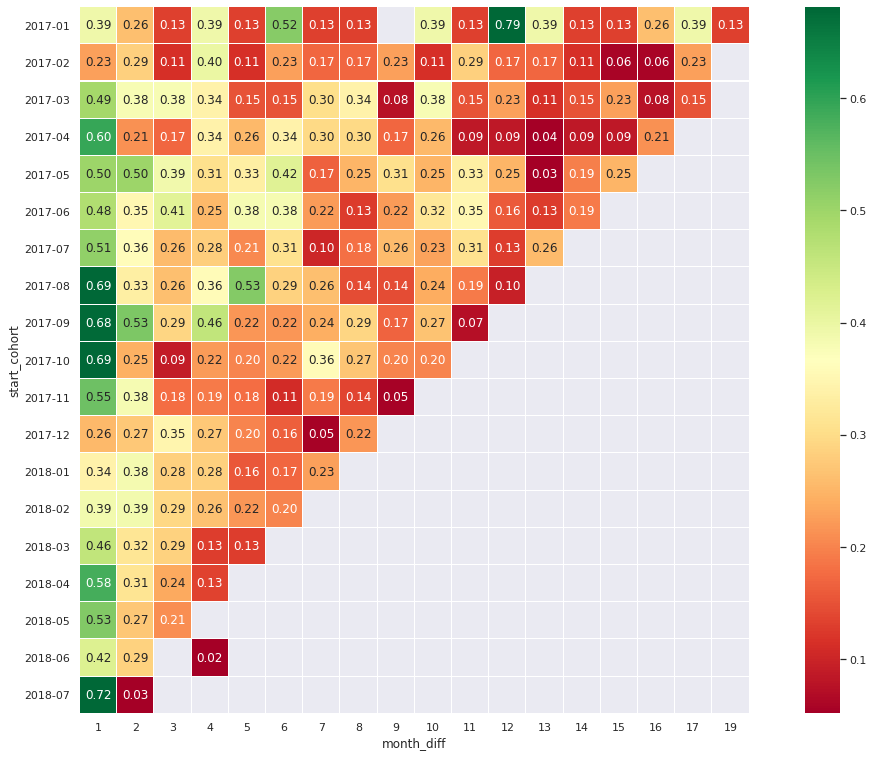

In [35]:
plt.figure(figsize=(20, 13))
ax = sns.heatmap(res_tab_2.drop(columns=[0, 20], index=['2016-09', '2016-10', '2016-12',
                                                '2018-08', '2018-09', '2018-10']),
                                                annot=True, fmt='.2f', cmap='RdYlGn',
                                                linewidths=.05, square=True, robust=True)
plt.show()

In [36]:
period = ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
          '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']
res_tab_2[res_tab_2.index.isin(period)][3].idxmax()

'2017-06'

# Задание № 6

Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

В кластеризации можешь выбрать следующие метрики: R, F, M. Подробно опиши, как ты создавал кластеры.

Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [37]:
df_rfm = orders_cust.merge(items, how='inner', on='order_id') # объединяю все 3 исходные таблицы

In [38]:
orders_rfm = df_rfm[['order_delivered_carrier_date', 'customer_unique_id', 'price']]\
      .rename(columns={'order_delivered_carrier_date': 'order_date',
                       'customer_unique_id'          : 'user_id',
                       'price'                       : 'order_value'})

In [39]:
orders_rfm.head()

,order_date,user_id,order_value
0,2017-10-04 19:55:00,7c396fd4830fd04220f754e42b4e5bff,29.99
1,2018-07-26 14:31:00,af07308b275d755c9edb36a90c618231,118.70
2,2018-08-08 13:50:00,3a653a41f6f9fc3d2a113cf8398680e8,159.90
3,2017-11-22 13:39:59,7c142cf63193a1473d2e66489a9ae977,45.00
4,2018-02-14 19:46:34,72632f0f9dd73dfee390c9b22eb56dd6,19.90


In [40]:
last_date = orders_rfm['order_date'].max() + timedelta(days=1)

In [41]:
last_date

Timestamp('2018-09-12 19:48:28')

In [42]:
RFM_data = orders_rfm.groupby('user_id').agg({'order_date'    : lambda x: (last_date - x.max()).days,
                                                 'user_id'    : lambda x: len(x), 
                                                 'order_value': lambda x: x.sum()})
RFM_data.rename(columns={'order_date'  : 'recency', 
                          'user_id'    : 'frequency', 
                          'order_value': 'monetary'}, inplace=True)

In [43]:
RFM_data.head()

,recency,frequency,monetary
user_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,123.0,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,126.0,1,18.90
0000f46a3911fa3c0805444483337064,548.0,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,333.0,1,25.99
0004aac84e0df4da2b147fca70cf8255,299.0,1,180.00


In [44]:
quantiles = RFM_data.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = RFM_data

In [45]:
def Quan(x,p,d):
     if x <= d[p][0.20]:
         return 1
     elif x <= d[p][0.40]:
         return 2
     elif x <= d[p][0.60]: 
         return 3
     elif x<=d[p][0.80]:
         return 4
     else:
         return 5

In [47]:
segmented_rfm['Recency'] = segmented_rfm['recency'].apply(Quan, args=('recency',quantiles,))
segmented_rfm['Frequency'] = segmented_rfm['frequency'].apply(Quan, args=('frequency',quantiles,))
segmented_rfm['Monetary'] = segmented_rfm['monetary'].apply(Quan, args=('monetary',quantiles,))
segmented_rfm['RFM_grade'] = segmented_rfm.Recency.map(str) + segmented_rfm.Frequency.map(str) + segmented_rfm.Monetary.map(str)
segmented_rfm['RFM_mean'] = (segmented_rfm.Recency + segmented_rfm.Frequency + segmented_rfm.Monetary) / 3
RFM_all = segmented_rfm[['Recency', 'Frequency', 'Monetary','RFM_grade', 'RFM_mean']]

In [52]:
RFM_all.head()

,Recency,Frequency,Monetary,RFM_grade,RFM_mean
user_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2,1,4,214,2.333333
0000b849f77a49e4a4ce2b2a4ca5be3f,2,1,1,211,1.333333
0000f46a3911fa3c0805444483337064,5,1,2,512,2.666667
0000f6ccb0745a6a4b88665a16c9f078,4,1,1,411,2.000000
0004aac84e0df4da2b147fca70cf8255,4,1,5,415,3.333333


# Визуализация RFM

 # Recency

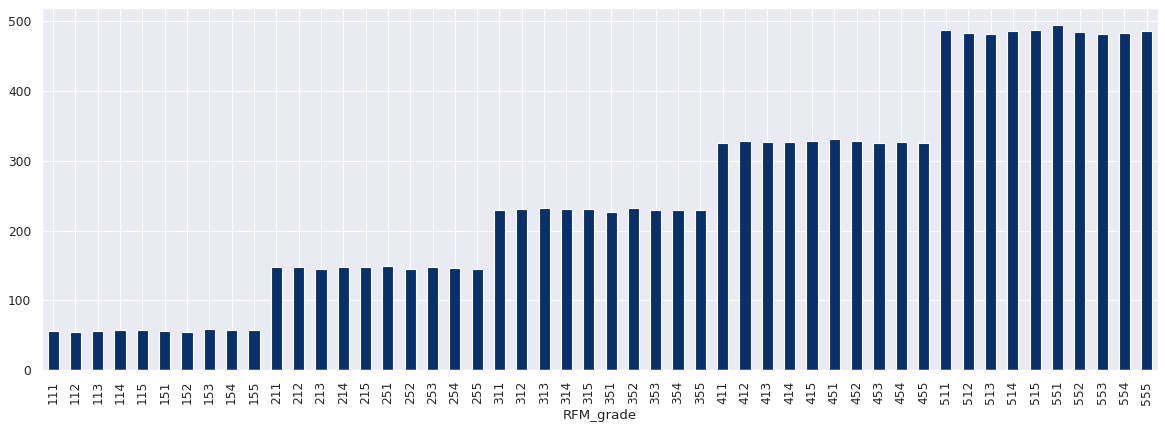

In [53]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFM_grade').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

# Frequency

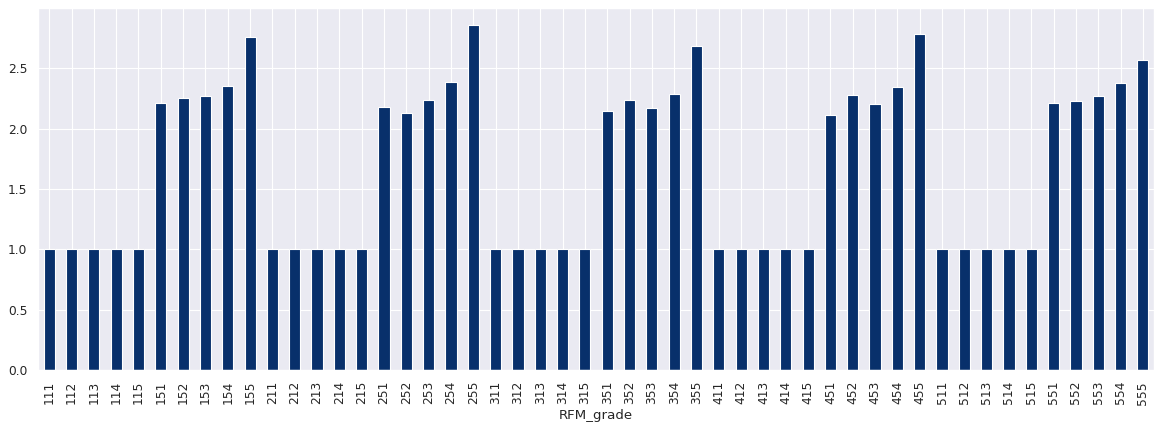

In [54]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFM_grade').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

# Monetary

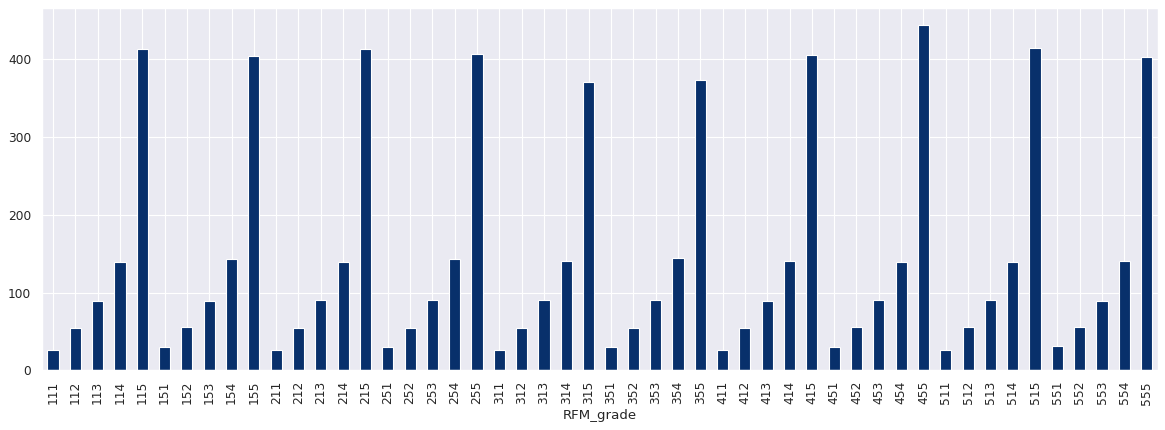

In [55]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFM_grade').agg('monetary').mean().plot(kind='bar', colormap='Blues_r')
plt.show()